In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

from pathlib import Path
import os, sys
# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
code_root = os.path.join(ipynb_dir, '..')
sys.path.append(code_root)  # Needed for import below

from sc2sensor.dataset import StarCraftSensor
from sc2sensor.dataset import LABELS_DICT, DEFAULT_10
from sc2sensor.utils.image_utils import imshow


root = os.path.join(code_root, 'data') # Data root directory
subdir = 'starcraft-sensor-dataset'
model_root_dir = model_dir

IMAGE_SIZE = [3, 32, 32]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Extract data for segmentation task
def get_sc2_image_and_unit_ids(dataset, idx):
  data_dict = dataset[idx]
  
  # Argmax over all players to get max value and max unit ids
  def flatten(p):
    max_idx = torch.argmax(data_dict[f'{p}_unit_values'], dim=0, keepdim=True) # (1, 64, 64)
    max_values = torch.gather(data_dict[f'{p}_unit_values'], dim=0, index=max_idx)
    max_values2 = torch.max(data_dict[f'{p}_unit_values'], dim=0, keepdim=True)[0] # (1, 64, 64)
    assert torch.all(max_values==max_values2), 'Max not working as expected'
    max_unit_ids = torch.gather(data_dict[f'{p}_unit_ids'], dim=0, index=max_idx) # (1, 64, 64)
    return max_values, max_unit_ids
  
  players = ['player_2', 'neutral', 'player_1'] # To match RGB channels
  player_data = [flatten(p) for p in players]
  
  # Convert to color image
  image, mask = [
    torch.cat([
      (d[i]*0.2 if (p == 'neutral' and i == 0) else d[i])
      for p, d in zip(players, player_data)
    ], dim=0)
    for i in range(2)
  ]
  
  # Argmax both players to get single player unit ids over mask
  max_idx = torch.argmax(image[[0,2]], dim=0, keepdim=True) # (1, 64, 64)
  unit_ids = torch.gather(mask[[0,2]], dim=0, index=max_idx) # (1, 64, 64)
  return image, unit_ids

In [3]:
# Currently slow as it creates some extra columns I think
sc2_train = StarCraftSensor(root, subdir, train=True, use_sparse=False)
sc2_test = StarCraftSensor(root, subdir, train=False, use_sparse=False)
# Note it is filtered 90% 10% by *matches* so not exactly 90-10 split for num of windows
print(len(sc2_train)) 
print(len(sc2_test))

Using cached CSV metadata
Using cached CSV metadata
1252866
138465


Automatic pdb calling has been turned ON


Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Chunks:   0%|          | 0/126 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/2866 [00:00<?, ?it/s]

Chunks:   0%|          | 0/14 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/10000 [00:00<?, ?it/s]

Windows:   0%|          | 0/8465 [00:00<?, ?it/s]

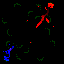

In [10]:
%pdb on
import PIL
# Setup directories
data_root = root
size = 'all'
if size == 'small':
  starcraft_segment_dir = os.path.join(data_root, subdir, 'segment_small')
  MAX_PER_CHUNK = 1000 # To avoid 65536 cap for 32 bit systems
  MAX_CHUNKS = 10
elif size == 'all':
  starcraft_segment_dir = os.path.join(data_root, subdir, 'segment')
  MAX_PER_CHUNK = 10000
  MAX_CHUNKS = torch.inf

train_test = [os.path.join(starcraft_segment_dir, 'train'), os.path.join(starcraft_segment_dir, 'test')]
image_dirs = [os.path.join(f, 'images') for f in train_test]
label_dirs = [os.path.join(f, 'labels') for f in train_test]
for d in [starcraft_segment_dir, *train_test, *image_dirs, *label_dirs]:
  if not os.path.exists(d):
    os.mkdir(d)
    
# Save the dataset as PNG images
from tqdm.notebook import tqdm
print('Warning: Probably should use window_idx instead of frame_idx but using frame_idx for now.')
for dataset, image_dir, label_dir in tqdm(zip([sc2_train, sc2_test], image_dirs, label_dirs), total=2, desc='Datasets'):
  idx = 0
  n_chunks = min(MAX_CHUNKS, int(torch.tensor(len(dataset)/MAX_PER_CHUNK).ceil()))
  for chunk_idx in tqdm(range(n_chunks), desc='Chunks'):
    chunk_image_dir = os.path.join(image_dir, f'{chunk_idx:02d}')
    chunk_label_dir = os.path.join(label_dir, f'{chunk_idx:02d}')
    for d in [chunk_image_dir, chunk_label_dir]:
      if not os.path.exists(d):
        os.mkdir(d)
    
    n_windows_left = len(dataset) - idx
    for _ in tqdm(range(min(n_windows_left, MAX_PER_CHUNK)), desc='Windows'):
      # Get replay and frame number for filename
      frame_idx = dataset.metadata.iloc[idx]['dynamic.frame_idx']
      replay_name = os.path.splitext(dataset.metadata.iloc[idx]['static.replay_name'])[0]

      # Construct filenames
      image_filename = os.path.join(chunk_image_dir, f'{replay_name}_{frame_idx}.png')
      label_filename = os.path.join(chunk_label_dir, f'{replay_name}_{frame_idx}_labels.png')
      
      # Only create if does not exist yet
      if not os.path.exists(image_filename):
        # Get data
        image, labels = get_sc2_image_and_unit_ids(dataset, idx)

        # Convert to PIL images
        # needs to be in (H, W, C) and uint8
        pil_image = PIL.Image.fromarray(image.permute(1, 2, 0).type(torch.uint8).numpy())
        labels_arr = labels.permute(1, 2, 0).type(torch.uint8).numpy()
        pil_labels = PIL.Image.fromarray(labels.squeeze(0).type(torch.uint8).numpy())

        # Save data as PNG files
        pil_image.save(image_filename)
        pil_labels.save(label_filename)

      # Always increment idx
      idx += 1
      #break # 1 image
    #break # 1 chunk
PIL.Image.open(image_filename)